In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np

adata=sc.read_h5ad('/home/share/huadjyin/home/zhouxuanchi/HIV_code/peak2gene/data/adata_process.h5ad',backed='r')


In [ ]:
gene_list=list(adata.var_names[:582])
del adata

In [ ]:
seperman=pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_correlation_mse.csv')
gene_list=seperman['Gene_Symbol'][:60].tolist()

df_list=[]
for gene in gene_list:
    df=pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/all/'+gene+'.csv')
    df_list.append(df)

result = pd.concat(df_list, axis=0)
result=result.iloc[:,:-1]

result.to_csv('peak2gene_sperman60_ig.csv', index=False)

In [ ]:
import torch
mat=torch.load('/home/share/huadjyin/home/zhouxuanchi/HIV_code/peak2gene/data/mask_mat.pt')

ma_np=mat.numpy()

In [ ]:
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    

def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
gene_all_list=load_data('/home/share/huadjyin/home/zhouxuanchi/HIV_code/peak2gene/data/list_gene_all.pkl')

spermantop60_gene_index=[]
for i in gene_list:
    spermantop60_gene_index.append(gene_all_list.index(i))
    
mat_sperman60=ma_np[spermantop60_gene_index]

In [ ]:
result=pd.read_csv('peak2gene_sperman60_ig.csv')
matrix_bool = mat_sperman60.astype(bool)
df_masked = result.where(matrix_bool)

mean_values = df_masked.mean()
mean_values.to_csv('sig.csv')
mean_values=pd.read_csv('sig.csv')
mean_values=mean_values.dropna()
mean_values['size'] = mean_values['0'].apply(lambda x: 'big' if x > 0.005 else 'small')
mean_values.to_csv('sig.csv')

In [ ]:
all = pd.read_csv("/home/share/huadjyin/home/zhouxuanchi/HIV_code/peak2gene/no_gene_only_peak_ig/sig.csv", index_col = 0) # 只考虑spearman大于0.8的60个基因的peak
all = all.rename(columns={'Unnamed: 0': 'Peak'})


In [ ]:
phast = pd.read_csv("/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/phastCons/peak_conservation_score.csv")

In [ ]:
merged_df = pd.merge(
    phast[['Peak', 'ConservationScore']],  # 保留 phast_unique 的 Peak 和 ConservationScore
    all[['Peak', 'size']],                       # 保留 all 的 Peak 和 size
    on='Peak',                                   # 按 Peak 列匹配
    how='left'                                   # 左连接，保留 phast_unique 的所有 Peak
)

In [13]:
merged_df["size"].value_counts()

size
big      692
small    403
Name: count, dtype: int64

/tmp/ipykernel_1036562/394865791.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

small vs. big: Custom statistical test, P_val:1.280e-05


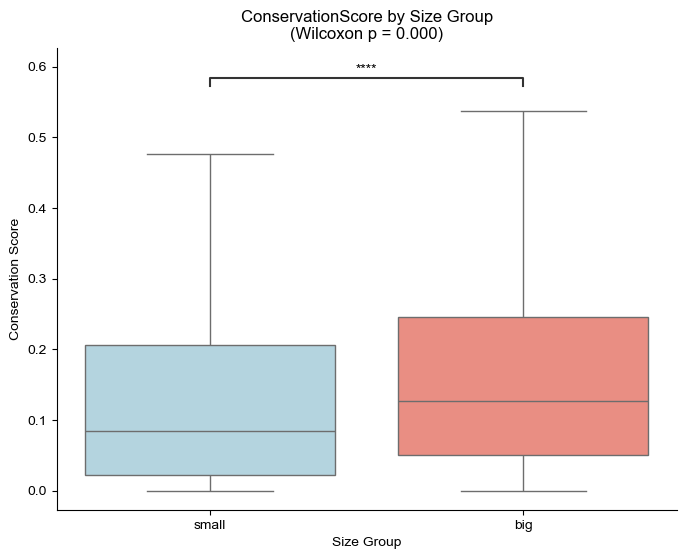

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statannotations.Annotator import Annotator
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False

# 1. 准备数据（假设 merged_df 已定义）
big_scores = merged_df[merged_df['size'] == 'big']['ConservationScore']
small_scores = merged_df[merged_df['size'] == 'small']['ConservationScore']

# 2. Wilcoxon 检验
stat, p_value = ranksums(big_scores, small_scores)

# 3. 绘制箱线图（不显示离群点）
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=merged_df,
    x='size',
    y='ConservationScore',
    order=['small', 'big'],
    palette={'small': 'lightblue', 'big': 'salmon'},
    showfliers=False  # 关键参数：不显示离群点
)

# 4. 添加显著性标记
annotator = Annotator(
    ax,
    pairs=[('small', 'big')],
    data=merged_df,
    x='size',
    y='ConservationScore',
    order=['small', 'big']
)
annotator.configure(text_format='star', loc='inside')
annotator.set_pvalues([p_value])
annotator.annotate()

plt.title('ConservationScore by Size Group\n(Wilcoxon p = {:.3f})'.format(p_value))
plt.xlabel('Size Group')
plt.ylabel('Conservation Score')
sns.despine()

#plt.savefig('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/phastCons/PhastCons_Score_Comparison.pdf')

plt.show()